# Welcome to my demo!!
##Dataset: student evaluations of 1025 physics courses at UCSD, **scraped** from web.
###summary statistics: 
- class size, 
- \# evaluations returned (~ attendance)
- \# hours spent studying / week
- expected grade
- **% students recommending course**
- **% students recommending instructor**

###objectives:
- *describe* this data
- *analyze* predictors of positive outcomes (high % students recommending class and/or instructor)

# Obtain data from cape.ucsd.edu/responses
### Locate desired data within html file, using "inspect element"
1. Item called "tbody" contains whole data table
2. Each row corresponds to a specific course, stored in "tr" items
3. Each data point (cell) stored in "td" items

### Put data points in 2D list

### To each row, append hyperlink to detailed course data (future analysis)

### Do some cleaning
1. Strip parentheses, %, extraneous spaces
2. Strip letter grades, leaving GPA only
3. Convert extracted strings to numeric types

In [134]:
def scrapeLocal():   
    
    '''output: list of summary statistics for all physics courses, 
    scraped from cape.uscd.edu'''
    from bs4 import BeautifulSoup
    import urllib2
    import re
    # scrape "web"
    page = urllib2.urlopen('file:///Users/cwylie/ipythonPracOct2015/insightDemo/cape/allPhysicsCapeSummary.html').read()
    soup = BeautifulSoup(page,"lxml")
    tableDat = soup.find("tbody")          # tbody is the tag of the whole table
    listTable = [[td.text for td in tr.findAll("td")] 
                 for tr in tableDat.findAll("tr")]  #tr = row, td = data point
    
    # now put links to detailed stats at the end of each row.  
    # Look out for key errors
    def graceful_href_extract(tr):
        try:
            return tr.a["href"]
        except KeyError:
            return ""
    # now go get hrefs
    trList=tableDat.findAll("tr")
    for i in range(0,len(trList)):
        listTable[i].append(graceful_href_extract(trList[i]))
        
    # clean listTable:
    # get rid of '(', ')', ' ', '%'
    stripListTable = [[ str(listTable[i][j]).replace('(','').replace(')','')
                       .replace('%','').strip() 
                   for j in range(0,len(listTable[0]))] for i in range(0,len(listTable)) ]

    # get rid of letter grade, leaving just GPA
    for i in range(0,len(stripListTable)):
        stripListTable[i][8] = re.sub("[^0123456789\.]", "", stripListTable[i][8])
        stripListTable[i][9] = re.sub("[^0123456789\.]", "", stripListTable[i][9])

    # function that facilitates casting string to float ('N/A' entries are problem)
    def graceful_float(x):
        try:
            return float(x)
        except ValueError:   # float('N/A') throws this error 
            return 'NaN'     # pandas is ok with 'NaN', but not 'N/A'

    # convert scraped strings to numeric types
    for i in range(0,len(stripListTable)):
        stripListTable[i][3] = int(stripListTable[i][3])
        stripListTable[i][4] = int(stripListTable[i][4])
        stripListTable[i][5] = graceful_float(stripListTable[i][5])
        stripListTable[i][6] = graceful_float(stripListTable[i][6])
        stripListTable[i][7] = graceful_float(stripListTable[i][7])
        stripListTable[i][8] = graceful_float(stripListTable[i][8])
        stripListTable[i][9] = graceful_float(stripListTable[i][9])
        
    return stripListTable

# Convert list to pandas data frame
- Column names correspond to html, except link to detailed data is in last column
- Make sure floats are represented as floats (and not "objects")

In [365]:
import pandas as pd

def capeListToPandas(stripListTable):
    # put list in pandas data frame    
    colNames= ['Instructor', 'Course','Term','Enroll','Evals',
               'Rcmnd_Class','Rcmnd_Instructor','Study_Hrs_Per_Wk',
               'Grade_Expected','Grade', 'Link']
    df = pd.DataFrame(stripListTable, columns=colNames)

    # make sure df[:][5:9] are floats
    df.Rcmnd_Class = df.Rcmnd_Class.astype(float)
    df.Rcmnd_Instructor = df.Rcmnd_Instructor.astype(float)
    df.Study_Hrs_Per_Wk = df.Study_Hrs_Per_Wk.astype(float)
    df.Grade_Expected = df.Grade_Expected.astype(float)
    df.Grade = df.Grade.astype(float)
    
    # define one last column: (proxy for) attendance
    df['Attendance']=df['Evals'] / df['Enroll'] 
    return df

df = capeListToPandas(scrapeLocal())

#That's me!

In [428]:
df[df['Instructor']=='Wylie, Christopher Scott']

,Instructor,Course,Term,Enroll,Evals,Rcmnd_Class,Rcmnd_Instructor,Study_Hrs_Per_Wk,Grade_Expected,Grade,Link,Attendance
919,"Wylie, Christopher Scott",PHYS 1B - Electricity and Magnetism A,SU08,57,45,86.4,100,6.37,3.36,NaN,https://cape.ucsd.edu/scripts/detailedStats.as...,0.789474


#Basic summary statistics

In [366]:
df.describe()

,Enroll,Evals,Rcmnd_Class,Rcmnd_Instructor,Study_Hrs_Per_Wk,Grade_Expected,Grade,Attendance
count,1025.000000,1025.000000,1022.000000,1022.000000,1022.000000,1010.000000,786.000000,1025.000000
mean,106.319024,45.400000,80.095988,78.567808,6.061448,3.369436,3.089911,0.445026
std,121.368912,54.582596,16.990485,20.831715,2.526226,0.306059,0.307910,0.181720
min,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.020000,0.000000
25%,22.000000,9.000000,71.400000,66.700000,4.355000,3.162500,2.862500,0.333333
50%,49.000000,20.000000,82.400000,84.000000,5.830000,3.350000,3.090000,0.419643
75%,175.000000,67.000000,92.300000,96.200000,7.500000,3.570000,3.340000,0.521739
max,840.000000,365.000000,100.000000,100.000000,20.500000,4.000000,3.930000,1.750000


In [369]:
from pylab import *
%matplotlib inline

#Analyze correlates and predictors of student satisfaction

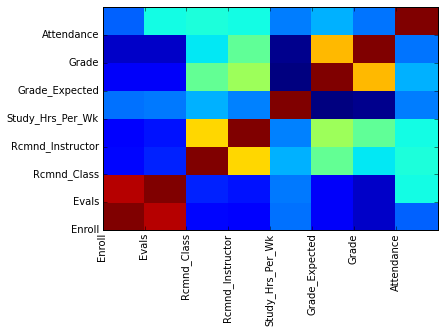

In [421]:
fig=figure()
ax=fig.add_subplot(1,1,1)
ax.pcolor(df.corr())

ax.set_xticklabels(df.corr().columns, rotation=90)
ax.set_yticklabels(df.corr().columns)


In [416]:
df.corr().sort('Rcmnd_Instructor', ascending=False)

,Enroll,Evals,Rcmnd_Class,Rcmnd_Instructor,Study_Hrs_Per_Wk,Grade_Expected,Grade,Attendance
Rcmnd_Instructor,-0.225767,-0.192750,0.558067,1.000000,-0.043559,0.361471,0.257379,0.127849
Rcmnd_Class,-0.210082,-0.171839,1.000000,0.558067,0.020696,0.259760,0.098794,0.142337
Grade_Expected,-0.242664,-0.243189,0.259760,0.361471,-0.394096,1.000000,0.599119,0.021556
Grade,-0.303081,-0.303403,0.098794,0.257379,-0.372841,0.599119,1.000000,-0.056930
Attendance,-0.086899,0.125865,0.142337,0.127849,-0.050797,0.021556,-0.056930,1.000000
Study_Hrs_Per_Wk,-0.064197,-0.053932,0.020696,-0.043559,1.000000,-0.394096,-0.372841,-0.050797
Evals,0.932455,1.000000,-0.171839,-0.192750,-0.053932,-0.243189,-0.303403,0.125865
Enroll,1.000000,0.932455,-0.210082,-0.225767,-0.064197,-0.242664,-0.303081,-0.086899


###Highlights
- Strong negative correlation (-0.2) b/w class size and student satisfaction with instructor
- Strong positive correlation (+0.4) b/w expected grade and student satisfaction with instructor
- Strong negative correlation (-0.3) b/w class size and grade
- Weak, **negative** correlation b/w workload and student satisfaction with instructor

#Next: Multivariate linear regression

In [415]:
numColNames=df.describe().columns
numData=df[numColNames]

df_num = pd.DataFrame(numData,columns=numColNames)
df_norm = (df_num - df_num.mean()) / df_num.std()

In [426]:
import statsmodels.formula.api as sm
result = sm.ols(formula=
                "Rcmnd_Instructor ~ Rcmnd_Class + Enroll + Study_Hrs_Per_Wk + Grade_Expected + Grade + Attendance",
                data=df_norm).fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:       Rcmnd_Instructor   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     66.42
Date:                Thu, 19 Nov 2015   Prob (F-statistic):           1.18e-66
Time:                        13:10:22   Log-Likelihood:                -947.56
No. Observations:                 785   AIC:                             1909.
Df Residuals:                     778   BIC:                             1942.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0330      0.030  

##highlights
- Class size is a **poor** predictor of student satisfaction w/ instructor (p > 0.6)
- Expected grade is a strong positive predictor of student satisfaction w/ instructor.
- Workload is a **positive** predictor of student satisfaction (p < 0.05)

# Time permitting: Split-Apply-Combine example
###Do instructors get better with experience?
- Group by instructor
- Count # records associated with each instructor (proxy for experience)
- Plot (mean)% recommended vs. "experience"

In [370]:
# To compare instructors, group by them
byInstructor = df.groupby('Instructor')   
nCoursesByInstructor=byInstructor.size()   
percentRecByInstructor = byInstructor['Rcmnd_Instructor'].mean() # dataframe->series: mean, avgd over all courses, of % recommended.  note: could weigh by # responses

def weightedPercentRecInstructor(df):
    '''% recommend instructor, weighted by # responses'''
    mask=df['Evals'].notnull() & df['Rcmnd_Instructor'].notnull()   # exclude nulls
    weightedRec = np.dot(df['Evals'][mask],df['Rcmnd_Instructor'][mask])/df['Evals'].sum()
    return weightedRec

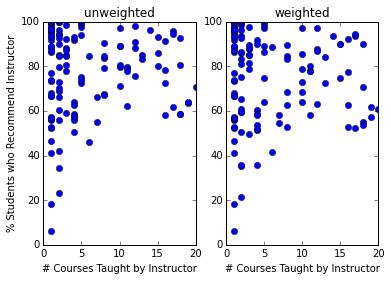

In [409]:
fig, axes=subplots(1, 2)
axes[0].plot(nCoursesByInstructor, percentRecByInstructor, 'o') 
axes[1].plot(nCoursesByInstructor, byInstructor.apply(weightedPercentRecInstructor),'o')

axes[0].set_xlabel('# Courses Taught by Instructor')
axes[1].set_xlabel('# Courses Taught by Instructor')
axes[0].set_ylabel('% Students who Recommend Instructor')
#title('Effect of Experience on Student Satisfaction')
axes[0].set_xlim([0,20])
axes[1].set_xlim([0,20])
axes[0].set_title('unweighted')
axes[1].set_title('weighted')

# What have you learned about me?
- I can scrape and clean data from the web
- I can program in python, in the visually pleasing jupyter notebook
- I have some proficiency with pandas (split + apply + combine)
- I have some proficiency with multiple linear regression

# What have you (we) learned about teaching at UCSD?
- Students are happy with instructors who award good grades, **and**
- Students are happy with instructors that make students work
- Class attendance is probably low (45% evaluations returned)
- Large class size does not **predict** unhappiness, but it is **correlated** with it
- Instructors do not seem to improve with increased experience